Importamos las librerías necesarias

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# For biosignal loading (like in your EDA/ECG scripts):
import biosignalsnotebooks as bsnb
from scipy.signal import butter, filtfilt
import neurokit2 as nk

# Example ML imports
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import os

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


In [ ]:
!pip install biosignalsnotebooks
!pip install neurokit2

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Aqui están definidas todas las funciones auxiliares que se utilizan para cargar y preprocesar las señales.

**Preprocesamiento de EDA:**  
Primero, se convierte la señal cruda de EDA de valores digitales a microSiemens (usando la resolución, el valor de VCC y el factor del sensor), y se le resta la media para eliminar el offset. Después, se aplica un filtro (por ejemplo, un filtro paso bajo Butterworth de orden 2) para atenuar las frecuencias altas. A continuación, se realiza un suavizado adicional con una media móvil y, finalmente, se submuestrea la señal para reducir su frecuencia de muestreo a 1 Hz y obtener una señal más manejable.

**Preprocesamiento de ECG:**  
Se convierten primero los valores digitales a milivoltios (mV) según la resolución y ganancia de amplificación, y se elimina la media para suprimir el offset. Luego, se aplica un filtro paso banda (por ejemplo, entre 0.5 y 40 Hz) para atenuar ruidos e irregularidades en frecuencias muy bajas y muy altas. Con la librería Neurokit se detectan los picos R, y a partir de estos se calculan los intervalos RR en segundos, generando una señal de intervalos que se interpola (si los picos son suficientes) y se filtra suavemente para estabilizar las variaciones abruptas.

In [ ]:
def preprocess_eda(raw_signal, sampling_rate):

    resolution_bits = 10
    vcc = 3.3
    factor = 0.132
    signal_us = ((raw_signal / (2**resolution_bits)) * vcc) / factor
    signal_us -= np.mean(signal_us)

    cutoff = 0.5  # 0.5 Hz
    b, a = butter(2, cutoff, btype='low', fs=sampling_rate)
    eda_filt = filtfilt(b, a, signal_us)

    window_sec = 5
    window_size = int(window_sec * sampling_rate)
    eda_smoothed = moving_average(eda_filt, window_size)

    target_fs = 1
    eda_down = downsample_signal(eda_smoothed, sampling_rate, target_fs)

    time_eda = np.linspace(0, len(eda_down)/target_fs, len(eda_down))
    return eda_down, time_eda, target_fs

def preprocess_ecg(raw_signal, sampling_rate):

    resolution_bits = 10
    vcc = 3300
    gain_ecg = 1100
    ecg_mv = (((raw_signal / (2**resolution_bits)) - 0.5) * vcc) / gain_ecg
    ecg_mv -= np.mean(ecg_mv)

    lowcut = 0.5
    highcut = 40.0
    b, a = butter(2, [lowcut, highcut], btype='band', fs=sampling_rate)
    ecg_filt = filtfilt(b, a, ecg_mv)

    peaks, info = nk.ecg_peaks(ecg_filt, sampling_rate=sampling_rate)
    rpeaks_idx = np.where(peaks["ECG_R_Peaks"] == 1)[0]

    rr_intervals = np.diff(rpeaks_idx) / sampling_rate
    rr_times = (rpeaks_idx[1:] + rpeaks_idx[:-1]) / (2.0 * sampling_rate)

    if len(rr_times) > 1:
        uniform_t = np.linspace(rr_times[0], rr_times[-1], len(rr_times))
        rr_uniform = np.interp(uniform_t, rr_times, rr_intervals)
    else:
        uniform_t = np.array([0])
        rr_uniform = np.array([0])

    if len(rr_uniform) > 2:
        fs_rr = 1.0 / (uniform_t[1] - uniform_t[0])
        cutoff_rr = 0.1
        b2, a2 = butter(2, cutoff_rr, btype='low', fs=fs_rr)
        rr_filt = filtfilt(b2, a2, rr_uniform)
    else:
        rr_filt = rr_uniform

    return ecg_filt, rpeaks_idx, uniform_t, rr_filt

def moving_average(data, window_size):
    """Simple moving average smoothing."""
    half_w = window_size // 2
    smoothed = []
    for i in range(len(data)):
        start = max(0, i - half_w)
        end = min(len(data), i + half_w)
        smoothed.append(np.mean(data[start:end]))
    return np.array(smoothed)

def downsample_signal(signal, original_fs, target_fs):
    """Downsample by integer factor."""
    factor = int(original_fs // target_fs)
    return signal[::factor]


Función para crear las ventanas

In [ ]:

def create_windows(time_array, signal_array, window_len, step, fs):
    """
    Segment the 'signal_array' into windows of length 'window_len' (s)
    with step 'step' (s), returning (start_time, end_time, segment).
    """
    segs = []
    w_size = int(window_len * fs)
    s_size = int(step * fs)

    idx = 0
    while idx + w_size <= len(signal_array):
        seg_data = signal_array[idx:idx+w_size]
        seg_t0 = time_array[idx]
        seg_tf = time_array[idx+w_size-1]
        segs.append((seg_t0, seg_tf, seg_data))
        idx += s_size

    return segs


Función para extraer las características. En nuestro caso, se extraen la media, la desviación estándar, rango y slope de la señal.


In [ ]:

def eda_features(segment):
    """
    Compute features for an EDA segment.
    (Add or remove as needed.)
    """
    mean_val = np.mean(segment)
    std_val  = np.std(segment)
    maximum  = np.max(segment)
    minimum  = np.min(segment)
    rng      = maximum - minimum
    # slope
    slope = np.polyfit(np.arange(len(segment)), segment, 1)[0] if len(segment) > 1 else 0.0
    return [mean_val, std_val, rng, slope]

def rr_features(segment):
    """
    Compute features for an RR-interval segment.
    """
    if len(segment) == 0:
        return [0,0,0,0]
    mean_val = np.mean(segment)
    std_val  = np.std(segment)
    maximum  = np.max(segment)
    minimum  = np.min(segment)
    rng = maximum - minimum
    slope = np.polyfit(np.arange(len(segment)), segment, 1)[0] if len(segment)>1 else 0.0
    return [mean_val, std_val, rng, slope]


Función para anotar las ventanas. En nuestro caso, se anota la ventana como 1 si la ventana contiene mayor número de samples con activación que de samples sin activación. En caso contrario, se anota como 0.

In [ ]:
path_diego ='/content/drive/MyDrive/DIEGO_UNI/4to/ADBF/ADBF/SNSDetComp'

In [ ]:
path_josu ='/content/drive/MyDrive/4Curso/ADBF/SNSDetComp'

In [ ]:

def get_window_label(t0, tf, sr, annotations_df):

    sample_start = int(t0 * sr)
    sample_end   = int(tf * sr)

    sample_col = annotations_df.iloc[:, 0]
    label_col  = annotations_df.iloc[:, 1]

    mask = (sample_col >= sample_start) & (sample_col < sample_end)
    subset_labels = label_col[mask]

    if len(subset_labels) == 0:
        return 0

    num_ones = (subset_labels == 1).sum()
    num_zeros = (subset_labels == 0).sum()

    if num_ones > num_zeros:
        return 1
    else:
        return 0

In [ ]:
DATA_DIR1 = path_diego + "/Grab1"
DATA_DIR2 = path_diego + "/Grab2"
WINDOW_LEN = 5  # seconds
STEP_LEN   = 1  # seconds

**Preprocesamiento de ambas señales (EDA y ECG):** Primero, para la señal de EDA se convierte el valor digital a microSiemens usando la resolución y el factor del sensor, se elimina la media (offset) y se aplica un filtro pasa-bajos (por ejemplo, 0.5 Hz) para atenuar el ruido de alta frecuencia; luego, se suaviza mediante una media móvil y se submuestrea la señal a 1 Hz para facilitar el procesado posterior. Para la señal de ECG, se convierte el valor digital a milivoltios en función de la resolución y la ganancia de amplificación, se filtra en banda (0.5-40 Hz) para eliminar ruidos e interferencias, y se detectan los picos R con Neurokit. A partir de estos picos, se calculan los intervalos RR (en segundos), se interpolan si es necesario y, finalmente, se aplica un filtrado adicional de baja frecuencia para estabilizar las fluctuaciones abruptas de la serie RR.

Processing file: /content/drive/MyDrive/DIEGO_UNI/4to/ADBF/ADBF/SNSDetComp/Grab1/ESTRES001_20250312_001_01.h5


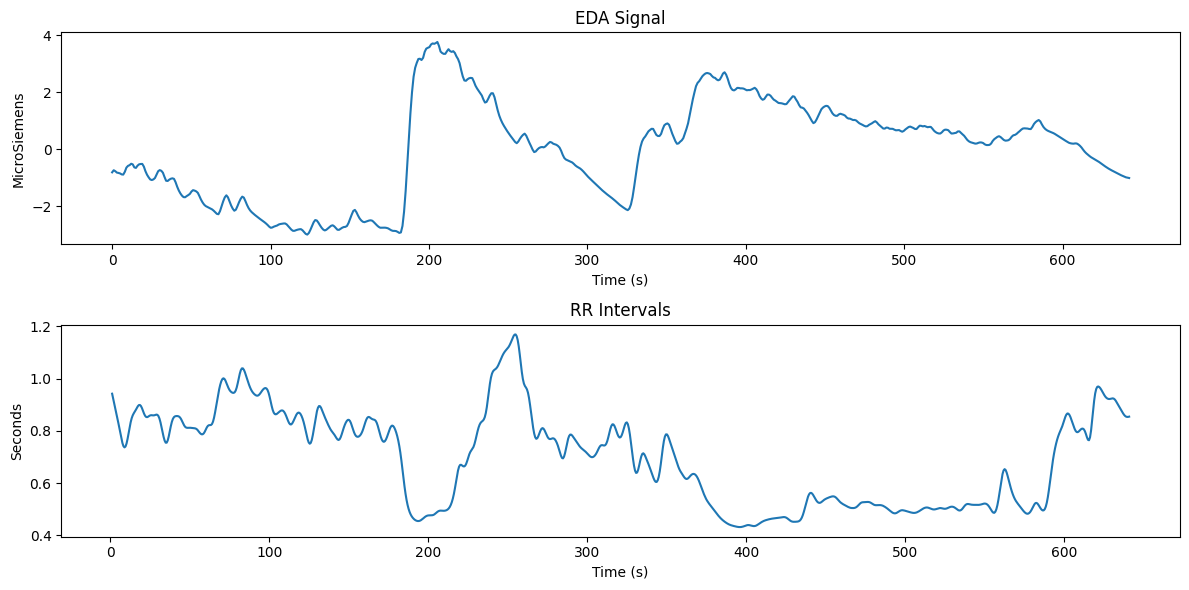

Processing file: /content/drive/MyDrive/DIEGO_UNI/4to/ADBF/ADBF/SNSDetComp/Grab1/ESTRES001_20250312_001_02.h5


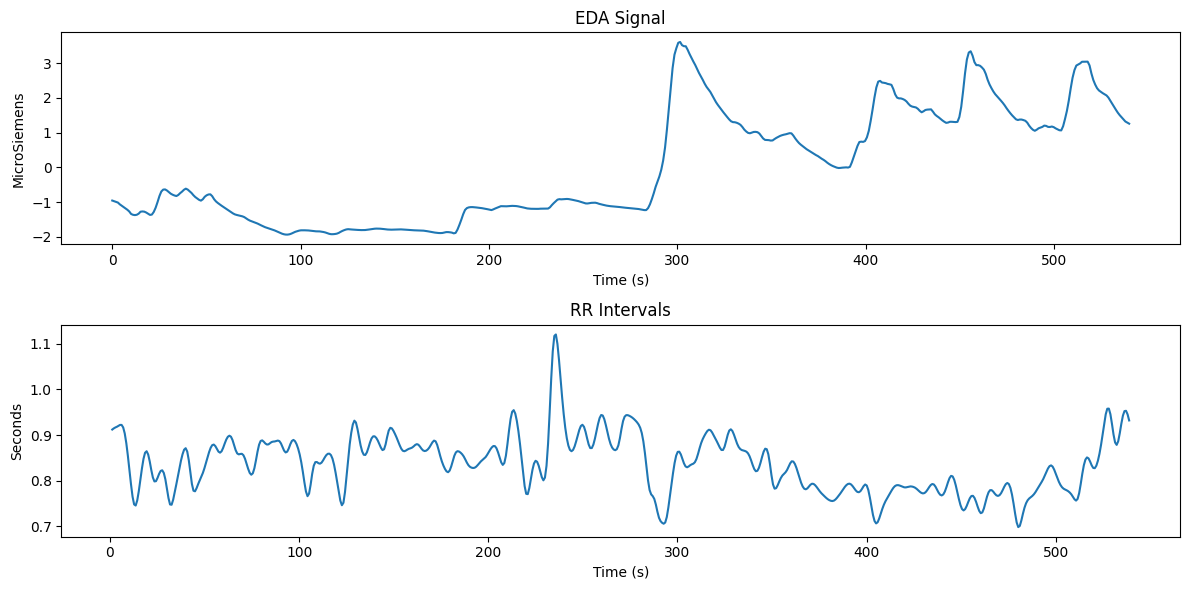

Processing file: /content/drive/MyDrive/DIEGO_UNI/4to/ADBF/ADBF/SNSDetComp/Grab1/ESTRES001_20250312_001_03.h5


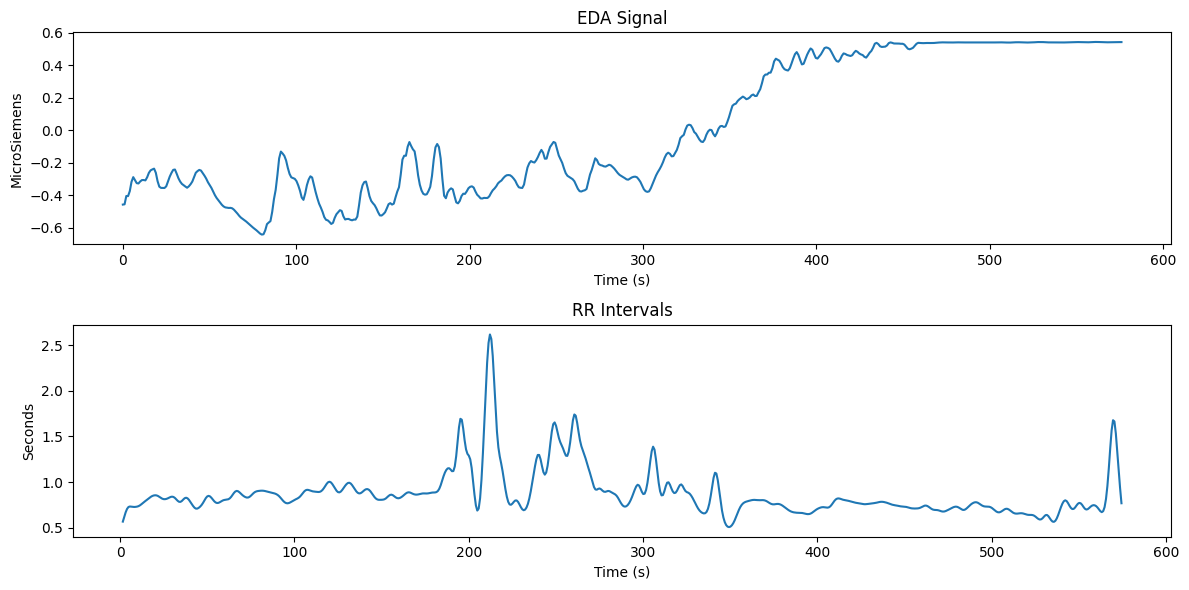

Processing file: /content/drive/MyDrive/DIEGO_UNI/4to/ADBF/ADBF/SNSDetComp/Grab1/ESTRES001_20250312_001_05.h5


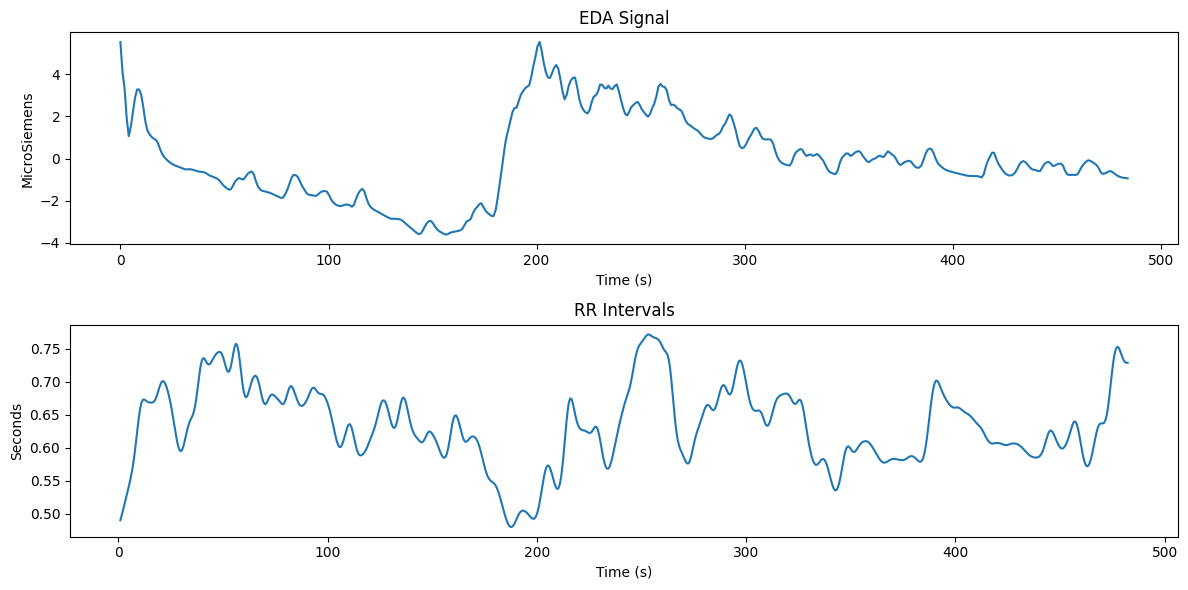

Processing file: /content/drive/MyDrive/DIEGO_UNI/4to/ADBF/ADBF/SNSDetComp/Grab1/ESTRES001_20250312_001_04.h5


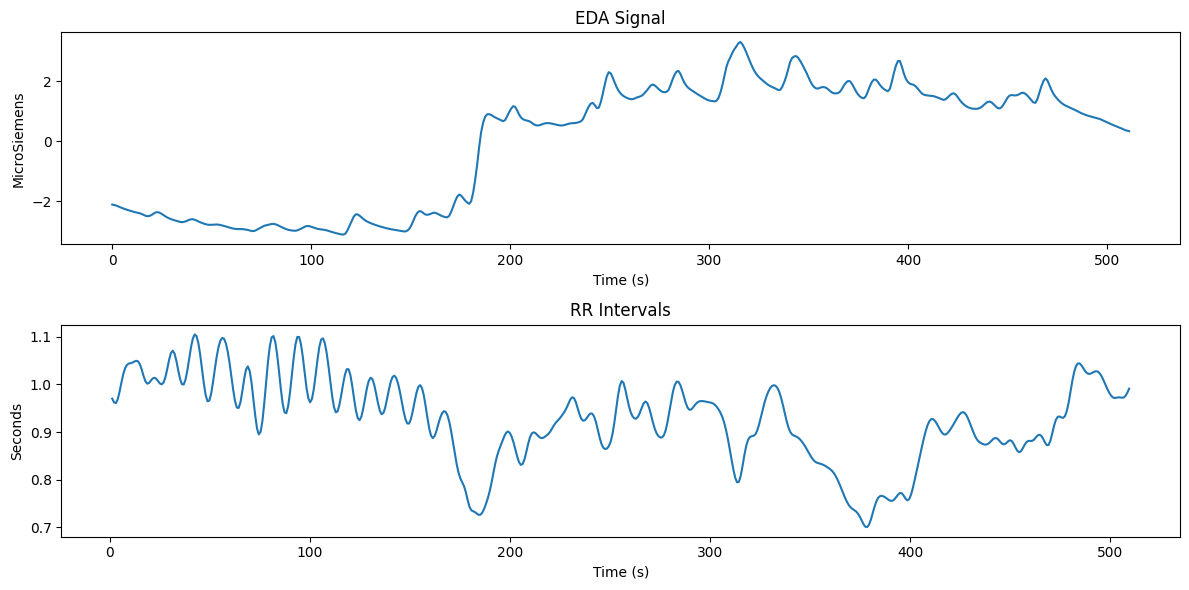

Processing file: /content/drive/MyDrive/DIEGO_UNI/4to/ADBF/ADBF/SNSDetComp/Grab2/ESTRES001_20250312_001_10.h5


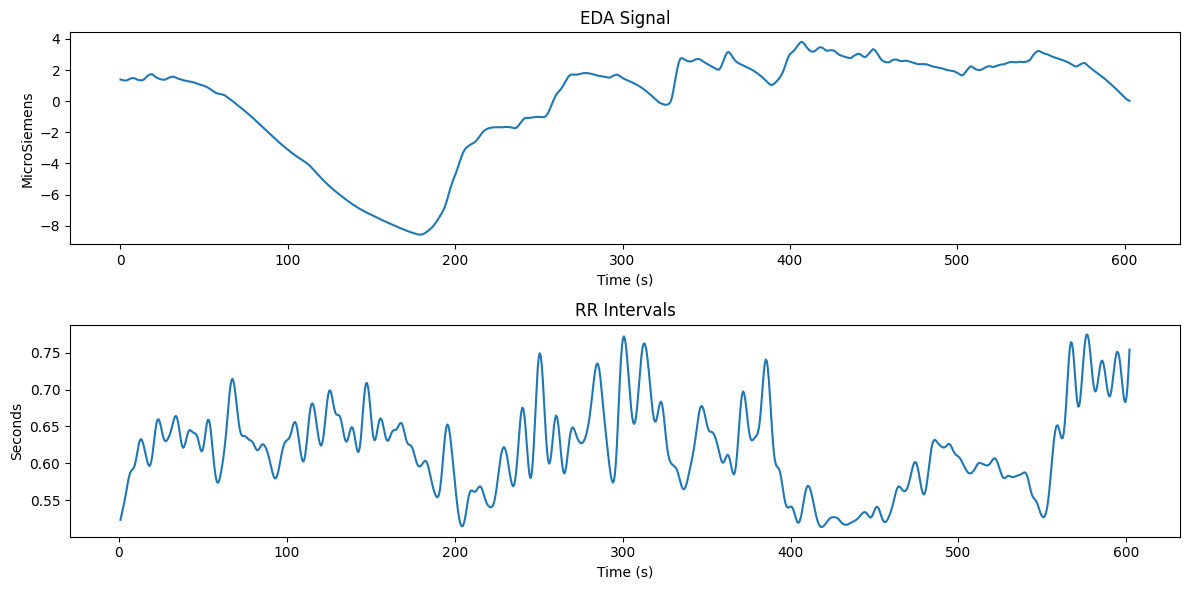

Processing file: /content/drive/MyDrive/DIEGO_UNI/4to/ADBF/ADBF/SNSDetComp/Grab2/ESTRES001_20250312_001_07.h5


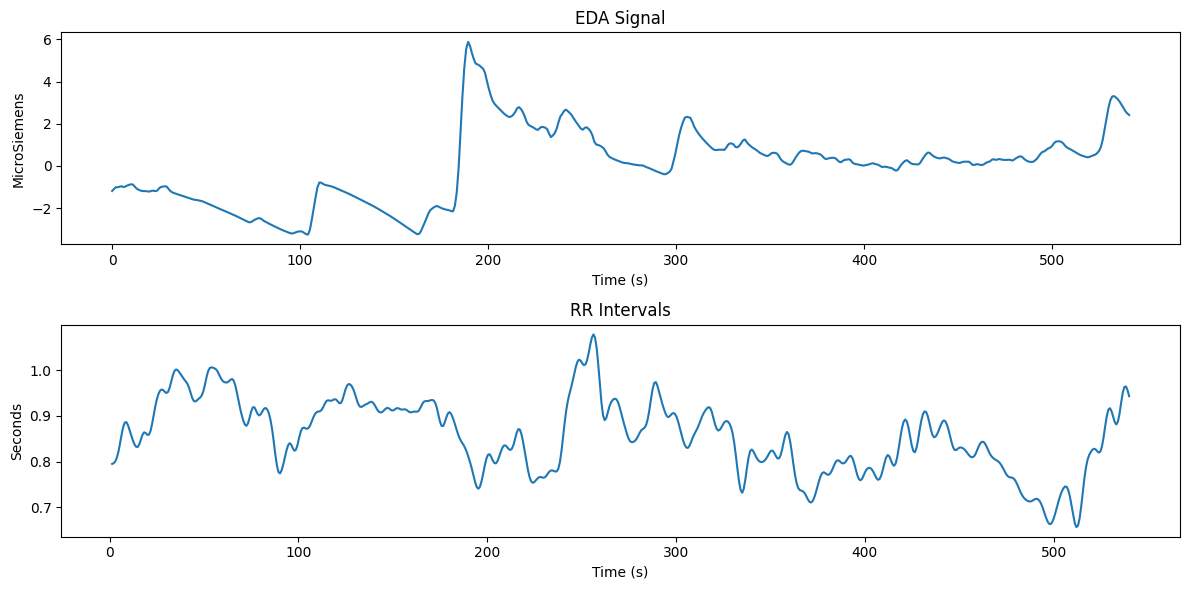

Processing file: /content/drive/MyDrive/DIEGO_UNI/4to/ADBF/ADBF/SNSDetComp/Grab2/ESTRES001_20250312_001_08.h5


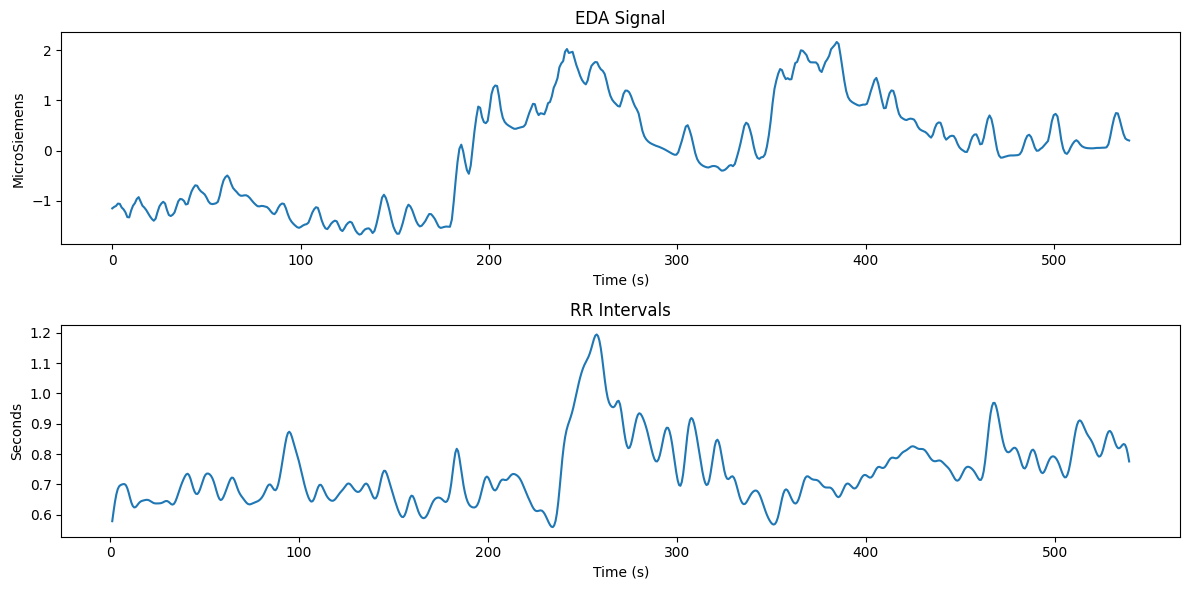

Processing file: /content/drive/MyDrive/DIEGO_UNI/4to/ADBF/ADBF/SNSDetComp/Grab2/ESTRES001_20250312_001_06.h5


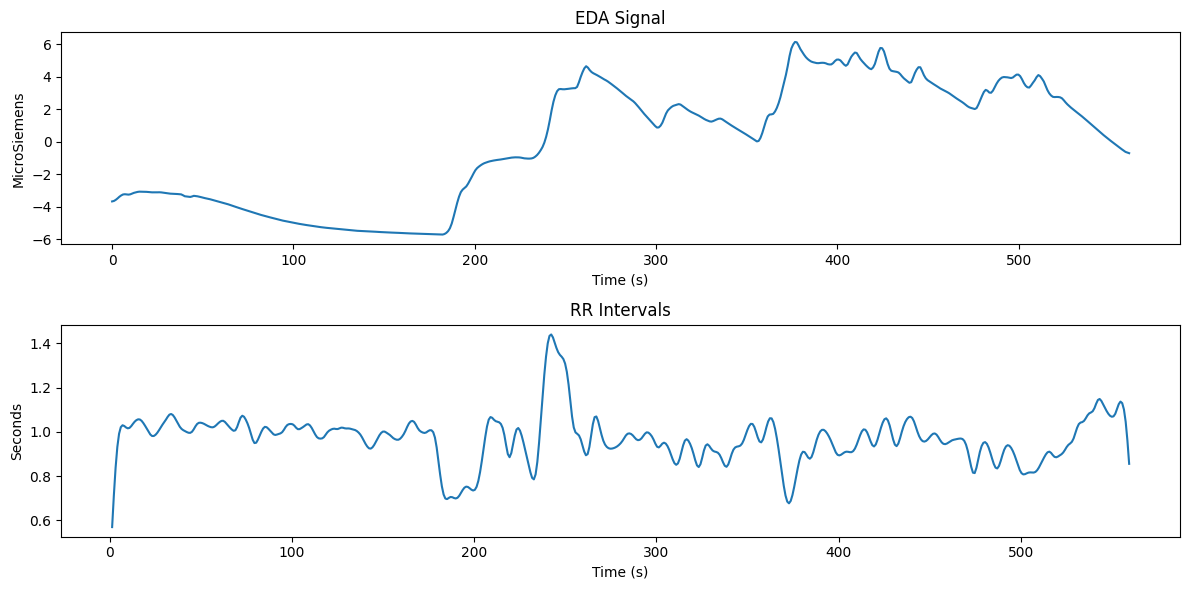

Processing file: /content/drive/MyDrive/DIEGO_UNI/4to/ADBF/ADBF/SNSDetComp/Grab2/ESTRES001_20250312_001_09.h5


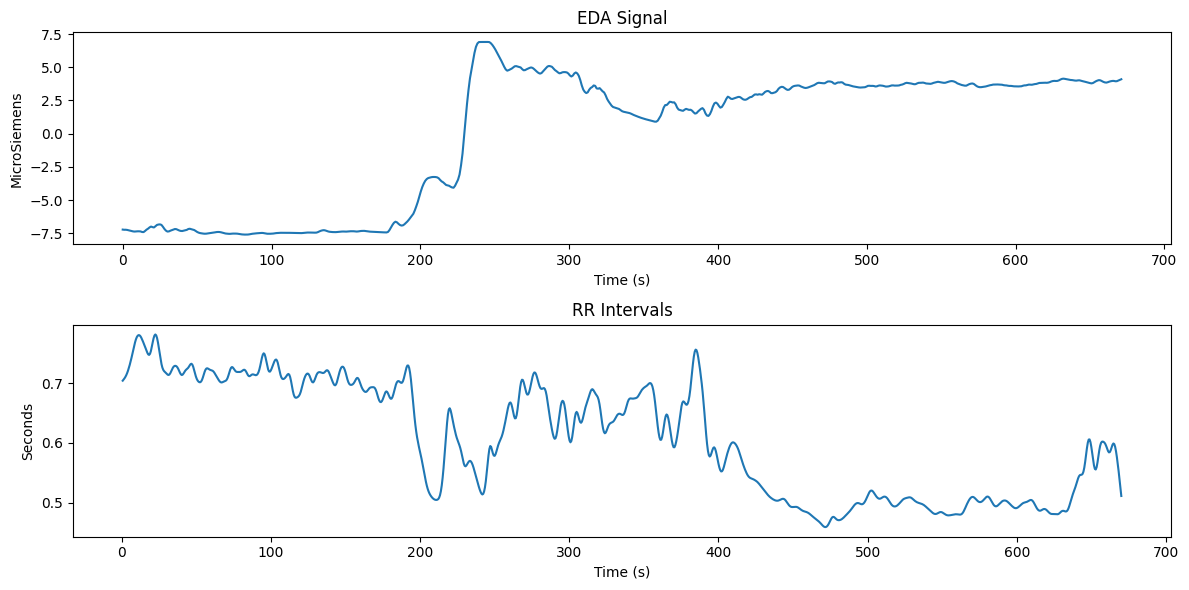

All subjects combined shape: (5629, 10)
   EDA_mean   EDA_std  EDA_range  EDA_slope   RR_mean    RR_std  RR_range  \
0 -0.790668  0.034940   0.094076  -0.012297  0.886380  0.036950  0.111303   
1 -0.798248  0.041346   0.111522  -0.028414  0.867646  0.037082  0.112072   
2 -0.827287  0.036854   0.112219  -0.025390  0.848699  0.037706  0.113753   
3 -0.851219  0.027717   0.070575  -0.019227  0.829597  0.038520  0.115297   
4 -0.845861  0.035475   0.097364   0.003649  0.810669  0.038724  0.114450   

   RR_slope  label                    file_id  
0 -0.018474    0.0  ESTRES001_20250312_001_01  
1 -0.018540    0.0  ESTRES001_20250312_001_01  
2 -0.018847    0.0  ESTRES001_20250312_001_01  
3 -0.019253    0.0  ESTRES001_20250312_001_01  
4 -0.019357    0.0  ESTRES001_20250312_001_01  


In [ ]:
all_subjects_data = []
for DATA_DIR in [DATA_DIR1, DATA_DIR2]:
  for file in os.listdir(DATA_DIR):
      if not file.endswith(".h5"):
          continue

      h5_path = os.path.join(DATA_DIR, file)
      base_name = os.path.splitext(file)[0]
      print(f"Processing file: {h5_path}")

      possible_annot = os.path.join(DATA_DIR, base_name + "_etiquetas.csv")
      if not os.path.isfile(possible_annot):
          print(f"Warning: No annotation file found for {h5_path} (looking for {possible_annot}). Skipping.")
          continue

      data_dict, header = bsnb.load(h5_path, get_header=True)

      eda_signal = data_dict["CH2"]
      ecg_signal = data_dict["CH1"]
      sr = header["sampling rate"]

      eda_proc, eda_time, eda_fs = preprocess_eda(eda_signal, sr)
      ecg_filt, rpeaks, rr_time, rr_filt = preprocess_ecg(ecg_signal, sr)

      """All signals are now preprocessed"""
      plt.figure(figsize=(12, 6))
      plt.subplot(2, 1, 1)
      plt.plot(eda_time, eda_proc)
      plt.title("EDA Signal")
      plt.xlabel("Time (s)")
      plt.ylabel("MicroSiemens")
      plt.subplot(2, 1, 2)
      plt.plot(rr_time, rr_filt)
      plt.title("RR Intervals")
      plt.xlabel("Time (s)")
      plt.ylabel("Seconds")
      plt.tight_layout()
      plt.show()


      eda_segments = create_windows(eda_time, eda_proc, WINDOW_LEN, STEP_LEN, eda_fs)
      if len(rr_time) < 2:
          print(f"Warning: Not enough R-peaks in {file} to build RR. Skipping RR features.")
          rr_segments = []
      else:
          if len(rr_time) > 1:
              fs_rr = 1.0 / (rr_time[1] - rr_time[0])
          else:
              fs_rr = 1.0
          rr_segments = create_windows(rr_time, rr_filt, WINDOW_LEN, STEP_LEN, fs_rr)

      annotations_df = pd.read_csv(possible_annot)

      X_eda = []
      seg_t_eda = []
      for seg in eda_segments:
          t0, tf, seg_data = seg
          feats = eda_features(seg_data)
          X_eda.append(feats)
          seg_t_eda.append((t0, tf))

      X_eda = np.array(X_eda)

      X_rr = []
      seg_t_rr = []
      for seg in rr_segments:
          t0, tf, seg_data = seg
          feats = rr_features(seg_data)
          X_rr.append(feats)
          seg_t_rr.append((t0, tf))

      X_rr = np.array(X_rr)

      min_len = min(len(X_eda), len(X_rr))
      X_eda = X_eda[:min_len]
      X_rr  = X_rr[:min_len]
      seg_t_eda = seg_t_eda[:min_len]
      X_combined = np.hstack([X_eda, X_rr])

      Y = []
      for i in range(min_len):
          t0_eda, tf_eda = seg_t_eda[i]
          label_i = get_window_label(t0_eda, tf_eda,sr, annotations_df)
          Y.append(label_i)

      Y = np.array(Y)

      columns_eda = ["EDA_mean","EDA_std","EDA_range","EDA_slope"]
      columns_rr  = ["RR_mean","RR_std","RR_range","RR_slope"]
      columns = columns_eda + columns_rr + ["label"]
      df_subject = pd.DataFrame(np.column_stack([X_combined, Y]), columns=columns)
      df_subject["file_id"] = base_name

      all_subjects_data.append(df_subject)

  # Combine all into one DataFrame
combined_df = pd.concat(all_subjects_data, axis=0, ignore_index=True) if all_subjects_data else None

if combined_df is not None:
    print("All subjects combined shape:", combined_df.shape)
    print(combined_df.head())
    combined_df.to_csv(path_diego + "/all_subjects_features.csv", index=False)
else:
    print("No data processed.")



Savethedataset

In [ ]:
combined_df.to_csv("all_subjects_features.csv", index=False)

# CLASIFICACIÓN

En esta parte del notebook vamos a evaluar diferentes clasificadores en la tarea de reconocer activaciones del sistema nervioso simpático.

## Estrategia de validación

Como estrategia de validación hemos elegido k-fold con k = 5, ya que es una técnica ampliamente utilizada en Machine Learning, y consigue evaluar el rendimiento de un modelo sobre diferentes conjuntos de train y validación. Así, conseguiremos ver sus capacidades en la clasificación de nuestras muestras.

## Clasifadores

Para hacer una prueba inicial, hemos probado cinco clasificadores diferentes. Los clasificadores utilizados han sido:

- Support Vector Machine (SVM)
- eXtreme Gradient Boosting (XGBoost)
- K Nearest Neighbor (KNN)
- Multi Layer Perceptron (MLP)
- Random Forest Classifier (RF)

Se han elegido estos cinco clasificadores por su rendimiento en tareas de clasificación con datos complejos y desbalanceados. SVM y XGBoost destacan por su capacidad para manejar datos no lineales y complejos, KNN por su simplicidad y capacidad de adaptación, MLP por su flexibilidad en redes neuronales, y Random Forest por su robustez y capacidad de manejar grandes volúmenes de datos con características importantes.

In [ ]:
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
import numpy as np

kf = KFold(n_splits=5)
classifiers = {
    "SVM": SVC(kernel='rbf', C=1, random_state=42),
    "XGBoost": GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42),
    "k-NN": KNeighborsClassifier(n_neighbors=5),
    "MLP": MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=42),
    "RFC": RandomForestClassifier(n_estimators=100, random_state=42)
}

from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, accuracy_score, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler

results = {}
for name, clf in classifiers.items():
    scores = []
    f1_scores = []
    roc_scores = []

    for train_index, test_index in kf.split(combined_df):
        X_train, X_test = combined_df.drop(["label", "file_id"], axis=1).iloc[train_index], combined_df.drop(["label", "file_id"], axis=1).iloc[test_index]
        Y_train, Y_test = combined_df["label"].iloc[train_index], combined_df["label"].iloc[test_index]

        scaler = StandardScaler().fit(X_train)
        X_train_scaled = scaler.transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        clf.fit(X_train_scaled, Y_train)
        Y_pred = clf.predict(X_test_scaled)

        acc = accuracy_score(Y_test, Y_pred)
        f1 = f1_score(Y_test, Y_pred, average="weighted")
        roc_auc = roc_auc_score(Y_test, Y_pred)

        scores.append(acc)
        f1_scores.append(f1)
        roc_scores.append(roc_auc)

    results[name] = {
        "Accuracy": np.mean(scores),
        "F1-Score": np.mean(f1_scores),
        "ROC-AUC": np.mean(roc_scores),
    }

    print(f"\n{name}:")
    print(f"  Accuracy: {results[name]['Accuracy']:.4f}")
    print(f"  F1-Score: {results[name]['F1-Score']:.4f}")
    print(f"  ROC-AUC: {results[name]['ROC-AUC']:.4f}")
    print(classification_report(Y_test, Y_pred))




SVM:
  Accuracy: 0.8282
  F1-Score: 0.7903
  ROC-AUC: 0.5813
              precision    recall  f1-score   support

         0.0       0.83      0.99      0.91       891
         1.0       0.87      0.25      0.39       234

    accuracy                           0.84      1125
   macro avg       0.85      0.62      0.65      1125
weighted avg       0.84      0.84      0.80      1125


XGBoost:
  Accuracy: 0.8172
  F1-Score: 0.7953
  ROC-AUC: 0.6080
              precision    recall  f1-score   support

         0.0       0.84      0.98      0.91       891
         1.0       0.80      0.30      0.44       234

    accuracy                           0.84      1125
   macro avg       0.82      0.64      0.67      1125
weighted avg       0.83      0.84      0.81      1125


k-NN:
  Accuracy: 0.7920
  F1-Score: 0.7808
  ROC-AUC: 0.6134
              precision    recall  f1-score   support

         0.0       0.84      0.96      0.90       891
         1.0       0.68      0.32      0.43   

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(



MLP:
  Accuracy: 0.8197
  F1-Score: 0.7972
  ROC-AUC: 0.6141
              precision    recall  f1-score   support

         0.0       0.84      0.97      0.90       891
         1.0       0.72      0.31      0.43       234

    accuracy                           0.83      1125
   macro avg       0.78      0.64      0.67      1125
weighted avg       0.82      0.83      0.80      1125


RFC:
  Accuracy: 0.8085
  F1-Score: 0.7904
  ROC-AUC: 0.6080
              precision    recall  f1-score   support

         0.0       0.84      0.96      0.89       891
         1.0       0.65      0.29      0.40       234

    accuracy                           0.82      1125
   macro avg       0.74      0.62      0.65      1125
weighted avg       0.80      0.82      0.79      1125



Como podemos ver, los clasificadores tienen un buen rendimiento en la detección de la clase negativa (0), pero luchan por identificar correctamente la clase positiva (1), con recall bajo en todos los casos. A pesar de tener alta precisión para la clase 0, ninguno de los modelos destaca en la identificación de los momentos de activación del SNS.

Esto puede sugerir que el dataset se encuentra desbalanceado:

In [34]:
print(combined_df["label"].value_counts())

label
0.0    4588
1.0    1041
Name: count, dtype: int64


Este desajuste en los datos produce que los modelos se centren en predecir adecuadamente el label 0 y no intenten clasificar adecuadamente las clases positivas. Ahora tenemos dos alternativas de balanceo:

- Reducir la cantidad de clases negativas de los datos
- Aumentar la cantidad de clases positivas mediante la creación de datos sintéticos.

Vamos a ver cuál de las dos opciones da mejores resultados.

### Opción 1: Submuestrear la clase 0

Esta opción tiene ventajas y desventajas. Por un lado, consigue balancear las clases. Sin embargo, hacer subsampleo significa eliminar muestras, lo cual siempre es una pérdida de información considerable.

In [ ]:
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn.utils import resample
from sklearn.metrics import classification_report, f1_score, roc_auc_score

kf = KFold(n_splits=5)
classifiers = {
    "SVM": SVC(kernel='rbf', C=1, random_state=42),
    "XGBoost": GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42),
    "k-NN": KNeighborsClassifier(n_neighbors=5),
    "MLP": MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=42),
    "RFC": RandomForestClassifier(n_estimators=100, random_state=42)
}

results = {}
for name, clf in classifiers.items():
    scores = []
    f1_scores = []
    roc_scores = []

    for train_index, test_index in kf.split(combined_df):
        X_train, X_test = combined_df.drop(["label", "file_id"], axis=1).iloc[train_index], combined_df.drop(["label", "file_id"], axis=1).iloc[test_index]
        Y_train, Y_test = combined_df["label"].iloc[train_index], combined_df["label"].iloc[test_index]

        scaler = StandardScaler().fit(X_train)
        X_train_scaled = scaler.transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        X_train_resampled, Y_train_resampled = resample(
            X_train_scaled[Y_train == 0], Y_train[Y_train == 0],
            replace=False, n_samples=(Y_train == 1).sum(), random_state=42)

        X_train_resampled = np.vstack([X_train_resampled, X_train_scaled[Y_train == 1]])
        Y_train_resampled = np.hstack([Y_train_resampled, Y_train[Y_train == 1]])

        if hasattr(clf, "class_weight"):
            clf.set_params(class_weight="balanced")

        clf.fit(X_train_resampled, Y_train_resampled)
        Y_pred = clf.predict(X_test_scaled)

        acc = accuracy_score(Y_test, Y_pred)
        f1 = f1_score(Y_test, Y_pred, average="weighted")
        roc_auc = roc_auc_score(Y_test, Y_pred)

        scores.append(acc)
        f1_scores.append(f1)
        roc_scores.append(roc_auc)

    results[name] = {
        "Accuracy": np.mean(scores),
        "F1-Score": np.mean(f1_scores),
        "ROC-AUC": np.mean(roc_scores),
    }

    print(f"\n{name}:")
    print(f"  Accuracy: {results[name]['Accuracy']:.4f}")
    print(f"  F1-Score: {results[name]['F1-Score']:.4f}")
    print(f"  ROC-AUC: {results[name]['ROC-AUC']:.4f}")
    print(classification_report(Y_test, Y_pred))



SVM:
  Accuracy: 0.7668
  F1-Score: 0.7843
  ROC-AUC: 0.7157
              precision    recall  f1-score   support

         0.0       0.91      0.84      0.87       891
         1.0       0.53      0.69      0.60       234

    accuracy                           0.81      1125
   macro avg       0.72      0.76      0.74      1125
weighted avg       0.83      0.81      0.82      1125


XGBoost:
  Accuracy: 0.7001
  F1-Score: 0.7271
  ROC-AUC: 0.6811
              precision    recall  f1-score   support

         0.0       0.87      0.85      0.86       891
         1.0       0.47      0.50      0.48       234

    accuracy                           0.78      1125
   macro avg       0.67      0.68      0.67      1125
weighted avg       0.78      0.78      0.78      1125


k-NN:
  Accuracy: 0.6852
  F1-Score: 0.7167
  ROC-AUC: 0.6642
              precision    recall  f1-score   support

         0.0       0.88      0.82      0.85       891
         1.0       0.45      0.56      0.50   

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(



MLP:
  Accuracy: 0.7220
  F1-Score: 0.7462
  ROC-AUC: 0.6906
              precision    recall  f1-score   support

         0.0       0.87      0.93      0.90       891
         1.0       0.63      0.47      0.54       234

    accuracy                           0.83      1125
   macro avg       0.75      0.70      0.72      1125
weighted avg       0.82      0.83      0.82      1125


RFC:
  Accuracy: 0.7039
  F1-Score: 0.7311
  ROC-AUC: 0.6796
              precision    recall  f1-score   support

         0.0       0.87      0.82      0.84       891
         1.0       0.44      0.53      0.48       234

    accuracy                           0.76      1125
   macro avg       0.65      0.67      0.66      1125
weighted avg       0.78      0.76      0.77      1125



Como podemos ver, el ROC-AUC, que sirve para medir la distinción entre clases, ha aumentado con respecto al intento anterior. Sin embargo, sigue siendo bajo para la mayoría de clasificadores.

### Opción 2: Resampleo de la clase 1

Esta opción se trata de crear datos sintéticos nuevos de la clase 1, realizando una interpolación. Por un lado, conseguimos que no se pierda información extra, pero por otro nos la jugamos a que un mal resampleo añada ruido y empeore la calidad de los datos.

In [ ]:
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
import numpy as np

kf = KFold(n_splits=5)
classifiers = {
    "SVM": SVC(kernel='rbf', C=1, random_state=42),
    "XGBoost": GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42),
    "k-NN": KNeighborsClassifier(n_neighbors=5),
    "MLP": MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=42),
    "RFC": RandomForestClassifier(n_estimators=100, random_state=42)
}

from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, accuracy_score, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler

results = {}
for name, clf in classifiers.items():
    scores = []
    f1_scores = []
    roc_scores = []

    for train_index, test_index in kf.split(combined_df):
        X_train, X_test = combined_df.drop(["label", "file_id"], axis=1).iloc[train_index], combined_df.drop(["label", "file_id"], axis=1).iloc[test_index]
        Y_train, Y_test = combined_df["label"].iloc[train_index], combined_df["label"].iloc[test_index]

        scaler = StandardScaler().fit(X_train)
        X_train_scaled = scaler.transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        smote = SMOTE(sampling_strategy="auto", random_state=42)
        X_train_resampled, Y_train_resampled = smote.fit_resample(X_train_scaled, Y_train)

        if hasattr(clf, "class_weight"):
            clf.set_params(class_weight="balanced")

        clf.fit(X_train_resampled, Y_train_resampled)
        Y_pred = clf.predict(X_test_scaled)

        acc = accuracy_score(Y_test, Y_pred)
        f1 = f1_score(Y_test, Y_pred, average="weighted")
        roc_auc = roc_auc_score(Y_test, Y_pred)

        scores.append(acc)
        f1_scores.append(f1)
        roc_scores.append(roc_auc)

    results[name] = {
        "Accuracy": np.mean(scores),
        "F1-Score": np.mean(f1_scores),
        "ROC-AUC": np.mean(roc_scores),
    }

    print(f"\n{name}:")
    print(f"  Accuracy: {results[name]['Accuracy']:.4f}")
    print(f"  F1-Score: {results[name]['F1-Score']:.4f}")
    print(f"  ROC-AUC: {results[name]['ROC-AUC']:.4f}")
    print(classification_report(Y_test, Y_pred))




SVM:
  Accuracy: 0.7357
  F1-Score: 0.7597
  ROC-AUC: 0.7082
              precision    recall  f1-score   support

         0.0       0.91      0.77      0.83       891
         1.0       0.45      0.72      0.55       234

    accuracy                           0.76      1125
   macro avg       0.68      0.74      0.69      1125
weighted avg       0.81      0.76      0.77      1125


XGBoost:
  Accuracy: 0.7280
  F1-Score: 0.7503
  ROC-AUC: 0.6848
              precision    recall  f1-score   support

         0.0       0.86      0.90      0.88       891
         1.0       0.55      0.46      0.50       234

    accuracy                           0.81      1125
   macro avg       0.71      0.68      0.69      1125
weighted avg       0.80      0.81      0.80      1125


k-NN:
  Accuracy: 0.7001
  F1-Score: 0.7246
  ROC-AUC: 0.6268
              precision    recall  f1-score   support

         0.0       0.87      0.88      0.87       891
         1.0       0.52      0.48      0.50   

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptro


MLP:
  Accuracy: 0.7174
  F1-Score: 0.7388
  ROC-AUC: 0.6468
              precision    recall  f1-score   support

         0.0       0.86      0.93      0.90       891
         1.0       0.64      0.44      0.52       234

    accuracy                           0.83      1125
   macro avg       0.75      0.69      0.71      1125
weighted avg       0.82      0.83      0.82      1125


RFC:
  Accuracy: 0.7685
  F1-Score: 0.7753
  ROC-AUC: 0.6576
              precision    recall  f1-score   support

         0.0       0.84      0.95      0.89       891
         1.0       0.63      0.34      0.44       234

    accuracy                           0.82      1125
   macro avg       0.74      0.64      0.67      1125
weighted avg       0.80      0.82      0.80      1125



En este caso el ROC-AUC ha aumentado también, aunque en menor medida que la opción 1. Por ello, nos quedaremos con esa opción.

### Elección del clasificador

Tras una primera toma de contacto, nos vamos a centrar en los modelos SVM y XGBoost.

### SVM

Tras ajustar los hiperparámetros de SVM, nos hemos quedado con C = 0.5 y un kernel RBF.

In [ ]:
kf = KFold(n_splits=5)

scores = []
f1_scores = []
roc_scores = []

for train_index, test_index in kf.split(combined_df):
    X_train, X_test = combined_df.drop(["label", "file_id"], axis=1).iloc[train_index], combined_df.drop(["label", "file_id"], axis=1).iloc[test_index]
    Y_train, Y_test = combined_df["label"].iloc[train_index], combined_df["label"].iloc[test_index]

    scaler = StandardScaler().fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    X_train_resampled, Y_train_resampled = resample(
        X_train_scaled[Y_train == 0], Y_train[Y_train == 0],
        replace=False, n_samples=(Y_train == 1).sum(), random_state=42)

    X_train_resampled = np.vstack([X_train_resampled, X_train_scaled[Y_train == 1]])
    Y_train_resampled = np.hstack([Y_train_resampled, Y_train[Y_train == 1]])

    clf = SVC(kernel='rbf', C=0.5, random_state=42)

    if hasattr(clf, "class_weight"):
        clf.set_params(class_weight="balanced")

    clf.fit(X_train_resampled, Y_train_resampled)
    Y_pred = clf.predict(X_test_scaled)

    acc = accuracy_score(Y_test, Y_pred)
    f1 = f1_score(Y_test, Y_pred, average="weighted")
    roc_auc = roc_auc_score(Y_test, Y_pred)

    scores.append(acc)
    f1_scores.append(f1)
    roc_scores.append(roc_auc)

results = {
    "Accuracy": np.mean(scores),
    "F1-Score": np.mean(f1_scores),
    "ROC-AUC": np.mean(roc_scores),
}

print(f"\n'SVM':")
print(f"  Accuracy: {results['Accuracy']:.4f}")
print(f"  F1-Score: {results['F1-Score']:.4f}")
print(f"  ROC-AUC: {results['ROC-AUC']:.4f}")
print(classification_report(Y_test, Y_pred))


'SVM':
  Accuracy: 0.7772
  F1-Score: 0.7918
  ROC-AUC: 0.7146
              precision    recall  f1-score   support

         0.0       0.91      0.85      0.88       891
         1.0       0.55      0.69      0.61       234

    accuracy                           0.82      1125
   macro avg       0.73      0.77      0.75      1125
weighted avg       0.84      0.82      0.82      1125



Los resultados son bastante buenos, consiguiendo detectar las activaciones con mejor score que en anteriores ocasiones.

### XGBoost

El clasificador XGBoost depende de el número de estimadores y el learning rate. Tras ajustar ambos hiperparámetros, hemos comprobado que un n_estimators = 30 consigue que el modelo aprenda pero no se sobreajuste. A su vez, hemos establecido el learning rate en 0.1.

In [ ]:
kf = KFold(n_splits=5)

from sklearn.metrics import classification_report, accuracy_score, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler

scores = []
f1_scores = []
roc_scores = []

for train_index, test_index in kf.split(combined_df):
    X_train, X_test = combined_df.drop(["label", "file_id"], axis=1).iloc[train_index], combined_df.drop(["label", "file_id"], axis=1).iloc[test_index]
    Y_train, Y_test = combined_df["label"].iloc[train_index], combined_df["label"].iloc[test_index]

    scaler = StandardScaler().fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    X_train_resampled, Y_train_resampled = resample(
        X_train_scaled[Y_train == 0], Y_train[Y_train == 0],
        replace=False, n_samples=(Y_train == 1).sum(), random_state=42)

    X_train_resampled = np.vstack([X_train_resampled, X_train_scaled[Y_train == 1]])
    Y_train_resampled = np.hstack([Y_train_resampled, Y_train[Y_train == 1]])

    clf = GradientBoostingClassifier(n_estimators=30, learning_rate=0.1, random_state=42)
    if hasattr(clf, "class_weight"):
        clf.set_params(class_weight="balanced")

    clf.fit(X_train_resampled, Y_train_resampled)
    Y_pred = clf.predict(X_test_scaled)

    acc = accuracy_score(Y_test, Y_pred)
    f1 = f1_score(Y_test, Y_pred, average="weighted")
    roc_auc = roc_auc_score(Y_test, Y_pred)

    scores.append(acc)
    f1_scores.append(f1)
    roc_scores.append(roc_auc)

results = {
    "Accuracy": np.mean(scores),
    "F1-Score": np.mean(f1_scores),
    "ROC-AUC": np.mean(roc_scores),
}

print(f"\nXGBoost:")
print(f"  Accuracy: {results['Accuracy']:.4f}")
print(f"  F1-Score: {results['F1-Score']:.4f}")
print(f"  ROC-AUC: {results['ROC-AUC']:.4f}")
print(classification_report(Y_test, Y_pred))


XGBoost:
  Accuracy: 0.7332
  F1-Score: 0.7559
  ROC-AUC: 0.7116
              precision    recall  f1-score   support

         0.0       0.89      0.89      0.89       891
         1.0       0.57      0.57      0.57       234

    accuracy                           0.82      1125
   macro avg       0.73      0.73      0.73      1125
weighted avg       0.82      0.82      0.82      1125



Con estos hiperparámetros, el modelo consigue un accuracy de 0.7332, un F1 de '.7559 y un ROC-AUC de 0.7116.

Finalmente, vamos a elegir el clasificador SVM, con el kernel rbf y C = 0.5.

# TEST

Leemos el conjunto de test y extraemos las características

In [ ]:
test_path = path_diego + "/Test"

In [ ]:
all_subjects_data = []
for file in os.listdir(test_path):
    if not file.endswith(".h5"):
        continue

    h5_path = os.path.join(test_path, file)
    base_name = os.path.splitext(file)[0]
    print(f"Processing file: {h5_path}")

    possible_annot = os.path.join(test_path, base_name + "_etiquetas.csv")
    if not os.path.isfile(possible_annot):
        print(f"Warning: No annotation file found for {h5_path} (looking for {possible_annot}). Skipping.")
        continue

    data_dict, header = bsnb.load(h5_path, get_header=True)

    eda_signal = data_dict["CH2"]
    ecg_signal = data_dict["CH1"]
    sr = header["sampling rate"]

    eda_proc, eda_time, eda_fs = preprocess_eda(eda_signal, sr)
    ecg_filt, rpeaks, rr_time, rr_filt = preprocess_ecg(ecg_signal, sr)

    eda_segments = create_windows(eda_time, eda_proc, WINDOW_LEN, STEP_LEN, eda_fs)
    if len(rr_time) < 2:
        print(f"Warning: Not enough R-peaks in {file} to build RR. Skipping RR features.")
        rr_segments = []
    else:
        if len(rr_time) > 1:
            fs_rr = 1.0 / (rr_time[1] - rr_time[0])
        else:
            fs_rr = 1.0
        rr_segments = create_windows(rr_time, rr_filt, WINDOW_LEN, STEP_LEN, fs_rr)

    annotations_df = pd.read_csv(possible_annot)

    X_eda = []
    seg_t_eda = []
    for seg in eda_segments:
        t0, tf, seg_data = seg
        feats = eda_features(seg_data)
        X_eda.append(feats)
        seg_t_eda.append((t0, tf))

    X_eda = np.array(X_eda)

    X_rr = []
    seg_t_rr = []
    for seg in rr_segments:
        t0, tf, seg_data = seg
        feats = rr_features(seg_data)
        X_rr.append(feats)
        seg_t_rr.append((t0, tf))

    X_rr = np.array(X_rr)

    min_len = min(len(X_eda), len(X_rr))
    X_eda = X_eda[:min_len]
    X_rr  = X_rr[:min_len]
    seg_t_eda = seg_t_eda[:min_len]
    X_combined = np.hstack([X_eda, X_rr])

    Y = []
    for i in range(min_len):
        t0_eda, tf_eda = seg_t_eda[i]
        label_i = get_window_label(t0_eda, tf_eda,sr, annotations_df)
        Y.append(label_i)

    Y = np.array(Y)

    columns_eda = ["EDA_mean","EDA_std","EDA_range","EDA_slope"]
    columns_rr  = ["RR_mean","RR_std","RR_range","RR_slope"]
    columns = columns_eda + columns_rr + ["label"]
    df_subject = pd.DataFrame(np.column_stack([X_combined, Y]), columns=columns)
    df_subject["file_id"] = base_name

    all_subjects_data.append(df_subject)

test_df = pd.concat(all_subjects_data, axis=0, ignore_index=True) if all_subjects_data else None


Processing file: /content/drive/MyDrive/DIEGO_UNI/4to/ADBF/ADBF/SNSDetComp/Test/ESTRESS01_test.h5


Ahora, entrenamos nuestro modelo con todas las muestras, normalizando también el test como hacemos en el train.

In [44]:
X_train, Y_train = combined_df.drop(["label", "file_id"], axis=1), combined_df["label"]
X_test, Y_test = test_df.drop(["label", "file_id"], axis=1), test_df["label"]

In [47]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.svm import SVC

X_train = combined_df.drop(["label", "file_id"], axis=1).iloc[:int(0.8 * len(combined_df))]
X_test = combined_df.drop(["label", "file_id"], axis=1).iloc[int(0.8 * len(combined_df)):]
Y_train = combined_df["label"].iloc[:int(0.8 * len(combined_df))]
Y_test = combined_df["label"].iloc[int(0.8 * len(combined_df)):]

scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

n_samples_minority = (Y_train == 1).sum()
X_train_resampled = np.vstack([
    X_train_scaled[Y_train == 0][:n_samples_minority],
    X_train_scaled[Y_train == 1]
])
Y_train_resampled = np.hstack([
    Y_train[Y_train == 0][:n_samples_minority],
    Y_train[Y_train == 1]
])

clf = SVC(kernel='rbf', C=0.5, random_state=42)
clf.fit(X_train_resampled, Y_train_resampled)

SVC(C=0.5, random_state=42)

Finalmente, testeamos con el conjunto de test y vemos resultados.

In [48]:
Y_pred = clf.predict(X_test_scaled)

accuracy = accuracy_score(Y_test, Y_pred)
f1 = f1_score(Y_test, Y_pred, average="weighted")
roc_auc = roc_auc_score(Y_test, Y_pred)

print("\nResultados finales en test:")
print(f"  Accuracy: {accuracy:.4f}")
print(f"  F1-Score: {f1:.4f}")
print(f"  ROC-AUC: {roc_auc:.4f}")
print(classification_report(Y_test, Y_pred))


Resultados finales en test:
  Accuracy: 0.5160
  F1-Score: 0.5535
  ROC-AUC: 0.6157
              precision    recall  f1-score   support

         0.0       0.89      0.45      0.59       892
         1.0       0.27      0.79      0.40       234

    accuracy                           0.52      1126
   macro avg       0.58      0.62      0.50      1126
weighted avg       0.76      0.52      0.55      1126



Podemos ver como se obtiene un accuracy del 51.6%, lo cual indica que el modelo no predice bien las pruebas de test. Principalmente, falla en la predicción de las activaciones.